In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/GO/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags); n_tags

[('The', 'O'), ('differences', 'O'), ('in', 'O'), ('their', 'O'), ('function', 'O'), ('are', 'O'), ('thought', 'O'), ('to', 'O'), ('stem', 'O'), ('from', 'O'), ('their', 'O'), ('different', 'O'), ('gene', 'O'), ('expression', 'O'), ('patterns', 'O'), ('morphologies', 'O'), ('and', 'O'), ('synaptic', 'GO:0045202'), ('connectivities', 'O')]


359

In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [6]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags, 1)}
tag2idx['0'] = 0
n_tags += 1

idx2tag = {v: k for k, v in tag2idx.iteritems()}

print word2idx['Hybrid']
print tag2idx["O"]

953
307


In [7]:
print tag2idx

{'GO:0007599': 1, 'GO:0007596': 2, 'GO:0006900': 3, 'GO:0001501': 4, 'GO:0001503': 5, 'GO:0006909': 6, 'GO:0065003': 296, 'GO:0043204': 8, 'GO:0043209': 9, 'GO:0005835': 10, 'GO:0005833': 11, '0': 0, 'GO:0016458': 12, 'GO:0016459': 13, 'GO:0018032': 14, 'GO:0006281': 15, 'GO:0006289': 16, 'GO:0007283': 17, 'GO:0007286': 18, 'GO:0001756': 19, 'GO:0001750': 20, 'GO:0000718': 21, 'GO:0045251': 22, 'GO:0006271': 23, 'GO:0009566': 24, 'GO:0020021': 25, 'GO:0006457': 26, 'GO:0000811': 27, 'GO:0005488': 28, 'GO:0050789': 29, 'GO:0042555': 30, 'GO:0042552': 31, 'GO:0043679': 32, 'GO:0006887': 33, 'GO:0005712': 34, 'GO:0005654': 35, 'GO:0005656': 36, 'GO:0005657': 37, 'GO:0032259': 38, 'GO:0043025': 39, 'GO:0019882': 40, 'GO:0007620': 41, 'GO:0009305': 42, 'GO:0007050': 43, 'GO:0043412': 44, 'GO:0043413': 45, 'GO:0000237': 46, 'GO:0000239': 47, 'GO:0000238': 48, 'GO:0000003': 49, 'GO:0030674': 50, 'GO:0005776': 185, 'GO:0005871': 52, 'GO:0019814': 53, 'GO:0005874': 54, 'GO:0045177': 306, 'GO:00

In [8]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=-1)

In [10]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [11]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [12]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [13]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [14]:
# from sklearn.utils import class_weight
# import numpy as np

# cw = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_tr),
#                                                  y_tr)

In [15]:
print np.shape(X_tr), np.shape(X_te), np.shape(y_tr), np.shape(y_te)

(8274, 75) (3546, 75) (8274, 75, 360) (3546, 75, 360)


In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=100,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.25))(model)  # variational biLSTM
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [17]:
model = Model(input, out)

In [18]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [19]:
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           1792100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 360)           72360     
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 360)           260280    
Total params: 2,285,540
Trainable params: 2,285,540
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=15,
                    validation_data=(X_te, np.array(y_te)), class_weight = 'auto', verbose=1)

Train on 8274 samples, validate on 3546 samples
Epoch 1/15
8274/8274 [==============================] - 134s 16ms/step - loss: 0.2567 - viterbi_acc: 0.9695 - val_loss: 0.1157 - val_viterbi_acc: 0.9790
Epoch 2/15
8274/8274 [==============================] - 133s 16ms/step - loss: 0.0965 - viterbi_acc: 0.9807 - val_loss: 0.0882 - val_viterbi_acc: 0.9806
Epoch 3/15
8274/8274 [==============================] - 132s 16ms/step - loss: 0.0751 - viterbi_acc: 0.9826 - val_loss: 0.0742 - val_viterbi_acc: 0.9836
Epoch 4/15
8274/8274 [==============================] - 131s 16ms/step - loss: 0.0614 - viterbi_acc: 0.9845 - val_loss: 0.0677 - val_viterbi_acc: 0.9842
Epoch 5/15
8274/8274 [==============================] - 132s 16ms/step - loss: 0.0531 - viterbi_acc: 0.9857 - val_loss: 0.0619 - val_viterbi_acc: 0.9849
Epoch 6/15
8274/8274 [==============================] - 132s 16ms/step - loss: 0.0471 - viterbi_acc: 0.9866 - val_loss: 0.0601 - val_viterbi_acc: 0.9858
Epoch 7/15
8274/8274 [============

In [21]:
hist = pd.DataFrame(history.history)

In [22]:
print hist

        loss  val_loss  val_viterbi_acc  viterbi_acc
0   0.256745  0.115743         0.978973     0.969516
1   0.096464  0.088212         0.980628     0.980749
2   0.075113  0.074223         0.983644     0.982627
3   0.061406  0.067748         0.984241     0.984549
4   0.053141  0.061873         0.984892     0.985676
5   0.047110  0.060064         0.985798     0.986580
6   0.042434  0.059648         0.984339     0.987379
7   0.039027  0.058216         0.986411     0.987896
8   0.036255  0.055749         0.984967     0.988343
9   0.033893  0.056705         0.985403     0.988712
10  0.031584  0.057653         0.985625     0.989092
11  0.029697  0.055663         0.984937     0.989308
12  0.027847  0.058161         0.984715     0.989614
13  0.026375  0.061939         0.983362     0.990012
14  0.024750  0.059672         0.984862     0.990215


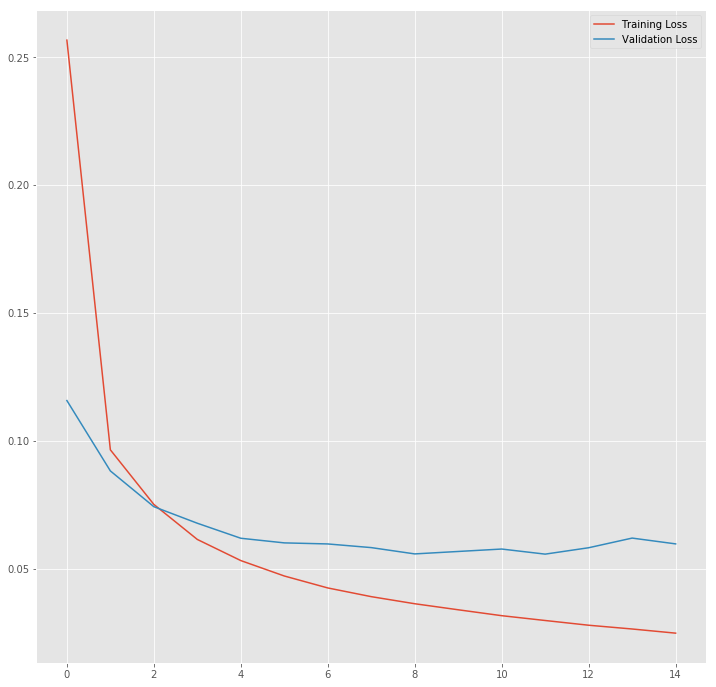

In [23]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

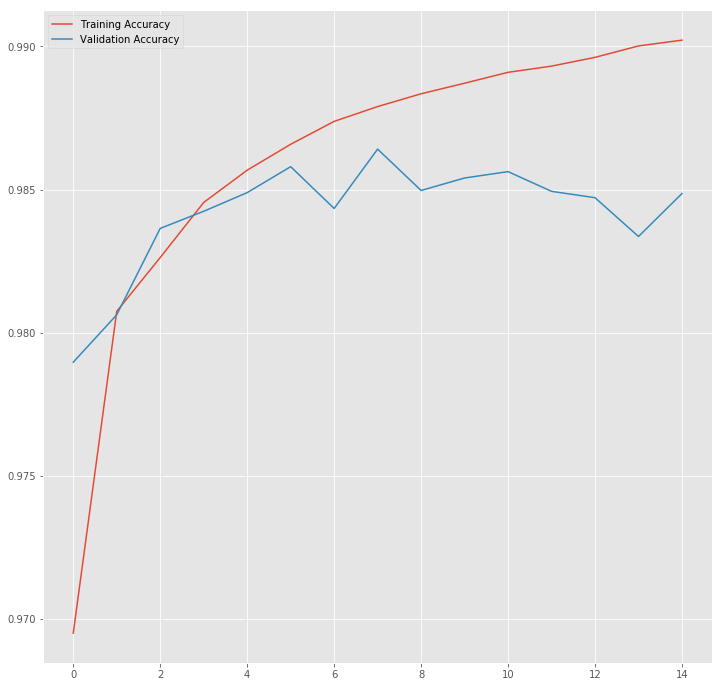

In [24]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["viterbi_acc"], label='Training Accuracy')
plt.plot(hist["val_viterbi_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import classification_report

predicted = model.predict(X_te)

true = []
predicted_val = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    predicted_val.append(p_tmp)
    true.append(t_tmp)

    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

print predicted_val[2]
print true[2]


print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307
 307 307 307 307 307 307 346 307 307 307 307 307 307 307 307 307 307 307
 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307
 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307
 307 307 307]
[307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307
 307 307 307 307 307 307 346 307 307 307 307 307 307 307 307 307 307 307
 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307
 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307 307
 307 307 307]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'GO:0010467', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
i = 300
pd = model.predict(np.array([X_te[i]]))
pd = np.argmax(pd, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for w, t1, pred in zip(X_te[i], true, pd[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t1-1], tags[pred-1]))

Word           ||True ||Pred
Strikingly     : O     O
Nr2e3          : O     O
itself         : O     O
was            : O     O
markedly       : O     O
upregulated    : O     O
in             : O     O
the            : O     O
rd7            : O     O
mutant         : O     O
both           : O     O
by             : O     O
microarray     : O     O
and            : O     O
in             : O     O
situ           : O     O
hybridization  : GO:0033592 GO:0033592
see            : O     O
Figure         : O     O
2              : O     O
lower          : O     O
right          : O     O
photomicrographs: O     O
Table          : O     O
S2             : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
representative : O     O
repres

In [27]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t))
}
)


In [28]:
df.to_csv('../data/results/LSTM_Based.tsv', sep='\t')

In [29]:
%run ./accuracy/src/computeSim.py ../data/results/LSTM_Based.tsv ../data/validation_data/GO_AllSubsumers.tsv

Mean semantic similarity:  0.492
